In [135]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.patches as mpatches  # For creating custom legend entries
from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display
import matplotlib as mpl
from matplotlib.lines import Line2D


# Configure global font size settings
mpl.rcParams.update({
    'font.size': 25,  # Default font size for titles, labels, and tick labels
    'axes.labelsize': 25,  # Font size for axis labels
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20,  # Font size for y-axis tick labels
    'legend.fontsize': 20  # Font size for the legend
})


# the graphs this script will generate:
## 1. local quality:
            x:  deletion_factor: fix user_input_size
            x:  complaint_ratio: fix user_input_size
            y:  fix rate + confirm preserve rate + global accuracy (before after)
## 2.3 strat comparison:
      x: user input size (fix complaint ratio, fix deletion factor)
      y: runtime, global_accuracy, fix rate, confirm preserve rate

In [136]:
# line_color_assignment_dict={'naive':'g','information_gain':'r', 'optimal': 'r'}
# Define a custom color palette using color names
custom_palette = ['#fed766','#2ab7ca','#fe4a49']

# Set the custom palette
sns.set_palette(custom_palette)

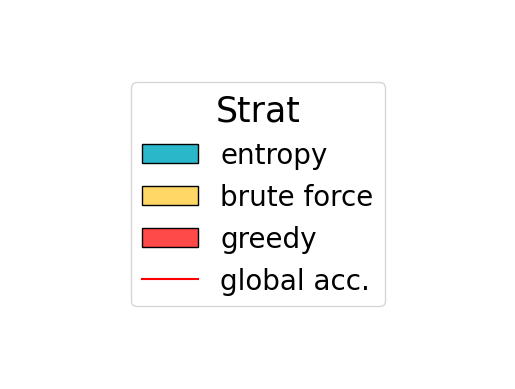

In [169]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    treefiles = glob.glob(f'{directory}*tree_*')
    print(treefiles)
    for f in treefiles:
        file = open(f)
        dot_string = file.read()
        print(f)
#             print(dot_string)
        graph = pydot.graph_from_dot_data(dot_string)[0]
        view_pydot(graph)
        print('\n')
            
def show_stats(directory):
    fs = glob.glob(f'{directory}*/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=10)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict, legend_pos,
#                group_name,
#                group_value, 
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
#     df=df[df[group_name]==group_value]
    # Create a scatter plot for each group based on shape and color
    groups = df.groupby(['strat'])
    for strat, group in groups:
        color = color_assignment_dict.get(strat)
        print(f'color: ')
        ax.plot(group[x], group[y], color=color, label=strat)
    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)


def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    strat_list = list(df['strat'].unique())
    strat_list.sort()
    ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list, 
                     boxprops={'linewidth': 2},
                    whiskerprops={'linewidth': 3},
                    medianprops={'linewidth': 3})
    if ylabel == 'new_global_accuracy':
        ax.axhline(y=float(df['global_accuracy'].unique()[0]), color='red', label='gloabl accuracy before fix',
                  linewidth=5)

    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

#     plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
       # Remove the legend
    ax.get_legend().remove()

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf",bbox_inches='tight', pad_inches=0.2)
    plt.show()



def line_plots_legends_only(color_assignment_dict):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Remove background grid
    ax.set_axis_off()

    # Create custom legend entries
    legend_entries = []

    for strat, color in color_assignment_dict.items():
        if strat == 'global acc.':
            # Create a line legend entry
            legend_entries.append(mlines.Line2D([], [], color=color, label=strat, markersize=30))
        else:
            # Create a rectangle legend entry
            legend_entries.append(mpatches.Patch(facecolor=color, edgecolor='black', label=strat))

    # Use Seaborn to add a legend
#     ax.legend(handles=legend_entries, loc='center', title='Strat')
    ax.legend(handles=legend_entries, loc='center', title='Strat')
    plt.savefig(f"graph_pdfs/box_legend_only.pdf", format="pdf",bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close(fig)

custom_palette = ['#2ab7ca','#fed766', '#fe4a49', 'red']
strats = ['entropy', 'brute force', 'greedy', 'global acc.']
color_dict = dict(zip(strats, custom_palette))

line_plots_legends_only(color_dict)

In [148]:
# 3 strat comparison

# df_3_strats= show_stats('../experiment_results_folders/all_lf_experiments_930/3_algo/')
# df_3_strats= show_stats('../experiment_results_folders/all_lf_experiments_1006/3_algo/')
df_3_strats= show_stats('../experiment_results_folders/all_lf_experiments_1012/3_algo/')

# /home/opc/author/RBBM/rbbm_src/experiment_results_folders

In [149]:
df_3_strats.loc[df_3_strats['strat']=='information_gain', 'strat'] = 'entropy'
df_3_strats.loc[df_3_strats['strat']=='naive', 'strat'] = 'greedy'
df_3_strats.loc[df_3_strats['strat']=='optimal', 'strat'] = 'brute_force'

In [150]:
df_3_strats.shape

(543, 27)

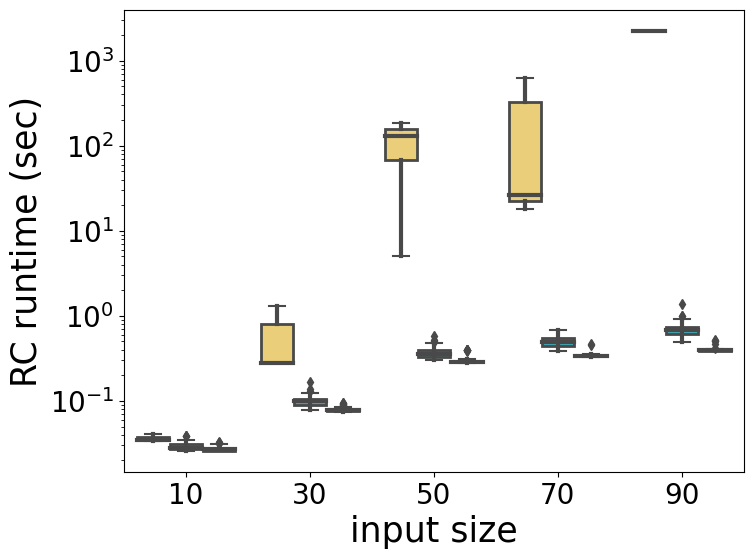

In [151]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='rbbm_runtime', 
#                                 xlabel='input_size', 
#                                 ylabel='runtime', 
#                                 title='input_size vs runtime', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='log',
#                                xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='rbbm_runtime', 
        xlabel='input size', 
        ylabel='RC runtime (sec)', 
        title='RuleCleaner_runtime (LF)', 
        yscale='log',
#         xticks=[10, 20, 30, 40, 60, 80, 100]
       )

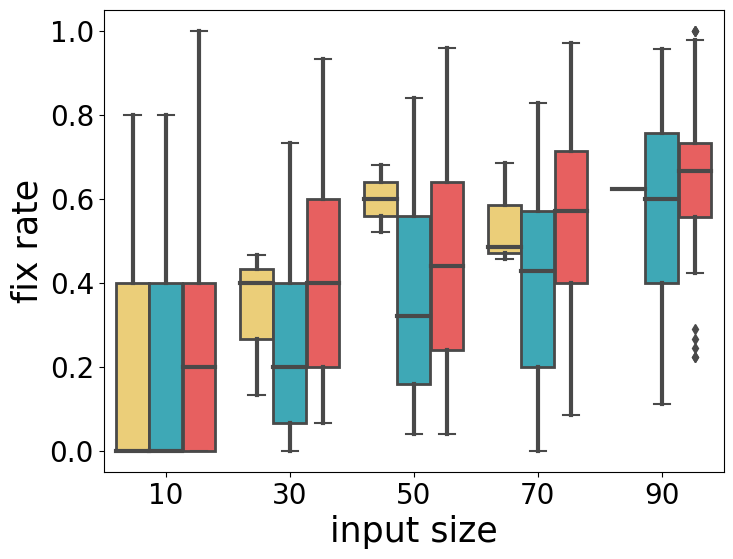

In [160]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='fix_rate', 
#                                 xlabel='input_size', 
#                                 ylabel='fix_rate', 
#                                 title='input_size vs fix_rate', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='linear',
#                                 xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='fix_rate', 
        xlabel='input size', 
        ylabel='fix rate', 
        title='fix_rate(LF)', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )

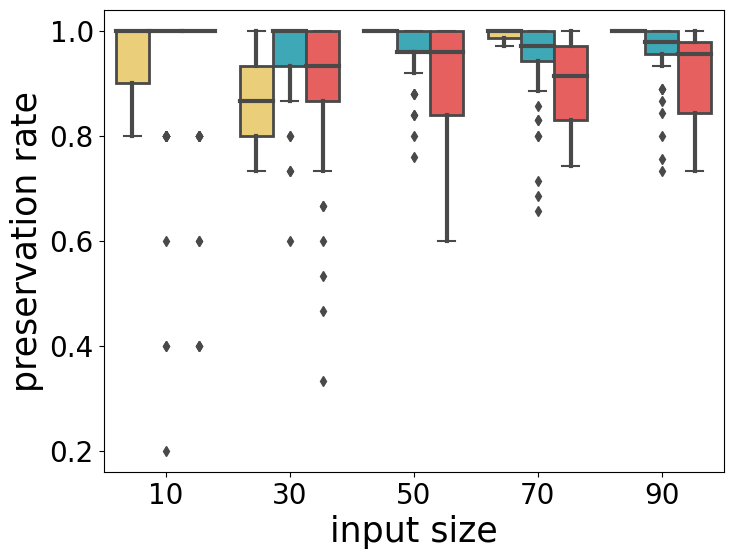

In [156]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='confirm_preserve_rate', 
#                                 xlabel='input_size', 
#                                 ylabel='confirm_preserve_rate', 
#                                 title='input_size vs confirm_preserve_rate', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='linear',
#                                 xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='confirm_preserve_rate', 
        xlabel='input size', 
        ylabel='preservation rate', 
        title='confirm_preserve_rate(LF)', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )

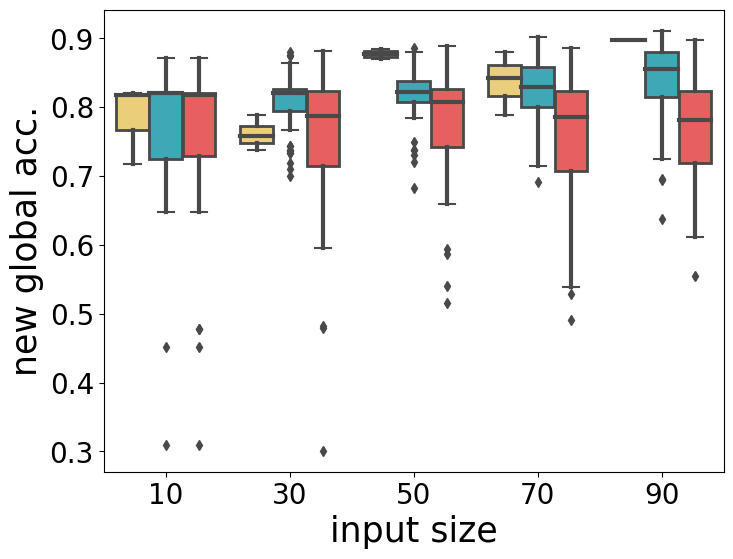

In [157]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='new_global_accuracy', 
#                                 xlabel='input_size', 
#                                 ylabel='new_global_accuracy', 
#                                 title='input_size vs new global accuracy after fix', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='linear',
#                                 xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='new_global_accuracy', 
        xlabel='input size', 
        ylabel='new global acc.', 
        title='new_global_accuracy(LF)', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )

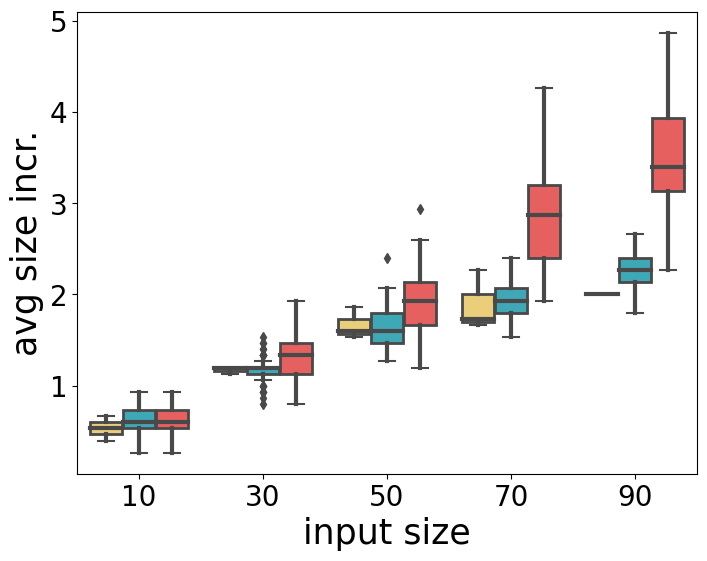

In [158]:
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='avg_tree_size_increase', 
        xlabel='input size', 
        ylabel='avg size incr.', 
        title='avg_tree_size_increase(LF)', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )